<a href="https://colab.research.google.com/github/NiallJeffrey/post-Newtonian/blob/master/nbody_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import time
import jax
# import numpy as np
import jax.numpy as np
from jax import jit
from jax.experimental.ode import odeint
import scipy.integrate as osp_integrate
from jax.ops import index, index_add, index_update
from jax.config import config
config.update("jax_enable_x64", True)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print('(GPU is often slower)')

cpu
(GPU is often slower)


In [2]:
@jit 
def acceleration_vector(r, Gm):
    return -Gm*r* (np.linalg.norm(r)**(-3))

@jit
def dydt(y,t,Gm):
  n_objects = len(Gm)
  r, v = y.reshape((2,n_objects,3))
  a = np.zeros(v.shape)

  # Loop over each i object to calculate forces
  for i in range(n_objects):
    # Sum over other j object contributions
    for j in range(n_objects):
      if i!=j: 
        # a[i] += acceleration_vector((r[i]-r[j]), Gm[j])
        a = index_add(a, index[i,:],acceleration_vector(r[i]-r[j], Gm[j]))

  return np.concatenate([v.flatten(), a.flatten()])
    

In [45]:
p1 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
p2 = np.array([1., 0., 0, 0., 3.,.0])
p3 = np.array([-2., 0., 0, 0., -2.1,.0])
p4 = np.array([9., 0., 0, 0., 1.,.0])
# print(p1)
# print(p2)
# print(p3)
# print(p4)
y0 = np.concatenate([p1[:3],p2[:3],p3[:3],p4[:3],p1[3:],p2[3:],p3[3:],p4[3:]])
# y0 = np.concatenate([p1[:3],p2[:3],p1[3:],p2[3:]])
Gm = np.array([9.,0.05, 0.05,0.05])

In [47]:
y0.reshape((2,4,3))

DeviceArray([[[ 0. ,  0. ,  0. ],
              [ 1. ,  0. ,  0. ],
              [-2. ,  0. ,  0. ],
              [ 9. ,  0. ,  0. ]],

             [[ 0. ,  0. ,  0. ],
              [ 0. ,  3. ,  0. ],
              [ 0. , -2.1,  0. ],
              [ 0. ,  1. ,  0. ]]], dtype=float64)

In [48]:
dydt(y0,0.,Gm).reshape((2,4,3))

DeviceArray([[[ 0.        ,  0.        ,  0.        ],
              [ 0.        ,  3.        ,  0.        ],
              [ 0.        , -2.1       ,  0.        ],
              [ 0.        ,  1.        ,  0.        ]],

             [[ 0.03811728, -0.        , -0.        ],
              [-9.00477431, -0.        , -0.        ],
              [ 2.25596878, -0.        , -0.        ],
              [-0.11230558, -0.        , -0.        ]]], dtype=float64)

In [49]:
tsteps = np.linspace(0, 5, 200)

In [50]:
%time jax_result_r, jax_result_v = odeint(dydt, y0, tsteps, Gm, rtol=1e-10).T.reshape(2,len(Gm),3, len(tsteps))

CPU times: user 4.79 s, sys: 62 ms, total: 4.85 s
Wall time: 4.86 s


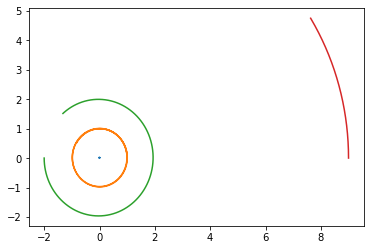

In [51]:
for i in range(4):  
  plt.plot(jax_result_r[i,0],jax_result_r[i,1])